In [138]:
import itertools
from contextlib import nullcontext
from enum import Enum
from typing import Any, Protocol, TypeVar

import matplotlib.pyplot as plt
import pandas as pd
import torchmetrics
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, TensorDataset


In [139]:
dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


### Общий код

In [140]:
preprocessor = ColumnTransformer(
    transformers=(
        (
            "num",
            StandardScaler(),
            make_column_selector(dtype_include=["int64"]),
        ),
    ),
)

In [141]:
class EpochMode(Enum):
    """Режим работы эпохи обучения."""

    TRAIN = 0
    INFERENCE = 1


class BatchMetricsHandlerProtocol(Protocol):
    """Обработчик полученных результатов во время обучения, нужен для расчета метрик."""

    def handle(self, logits: torch.Tensor, targets: torch.Tensor, loss: torch.Tensor, mode: EpochMode) -> None:
        """Метод который должен обрабатывать полученные результаты для батча из нейросети."""
        ...

    def epoch_end(self, mode: EpochMode) -> None:
        """Метод который вызывается в конце каждой эпохи."""
        ...

    def end_learning(self) -> None:
        """Вызывается в конце обучения."""


T_TRAIN_LOADER_co = TypeVar("T_TRAIN_LOADER_co", covariant=True)
T_VAL_LOADER_co = TypeVar("T_VAL_LOADER_co", covariant=True)


class Trainer:
    """Класс пайплайн обучения модели на основе нейросетей."""

    def __init__(  # noqa: PLR0913
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader[T_TRAIN_LOADER_co],
        val_loader: DataLoader[T_VAL_LOADER_co],
        device: str = "cpu",
        metrics_handler: BatchMetricsHandlerProtocol | None = None,
    ) -> None:
        """Инициализация пайплайна."""
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.metrics_handler = metrics_handler

    def _run_epoch(self, mode: EpochMode) -> None:
        """Запуск одной эпохи обучения.

        Если mode Train, то будет использован train_loader, модель переведена в режим обучения,
        иначе будет производится оценка модели на данных из val_loader.
        """
        loader = self.train_loader if mode is EpochMode.TRAIN else self.val_loader
        self.model.train() if mode is EpochMode.TRAIN else self.model.eval()
        context = nullcontext() if mode is EpochMode.TRAIN else torch.inference_mode()

        with context:
            for features, targets in loader:
                features_in_device, targets_in_device = features.to(self.device), targets.to(self.device)

                logits = self.model(features_in_device)
                loss = self.loss_fn(logits, targets_in_device)

                if mode is EpochMode.TRAIN:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                if self.metrics_handler is not None:
                    self.metrics_handler.handle(logits, targets_in_device, loss, mode)

            if self.metrics_handler is not None:
                self.metrics_handler.epoch_end(mode)

    def fit(self, epochs: int) -> None:
        """Запуск обучения модели."""
        for _epoch in tqdm(range(epochs), desc="Epoch", leave=True):
            self._run_epoch(mode=EpochMode.TRAIN)
            if self.metrics_handler is not None:
                self._run_epoch(mode=EpochMode.INFERENCE)

        if self.metrics_handler is not None:
            self.metrics_handler.end_learning()

In [142]:
class PokemonClassifierMetricsHandler(BatchMetricsHandlerProtocol):
    """Обработчик для вычисления метрик классификатора покемонов."""

    def __init__(self, train_dataset_len: float, val_dataset_len: float, device: str):
        super().__init__()
        self.train_dataset_len = train_dataset_len
        self.val_dataset_len = val_dataset_len
        self.batch_loss = 0.0
        self.all_preds = []
        self.all_targets = []
        self.train_loss: list[float] = []
        self.train_f1: list[float] = []
        self.train_acc: list[float] = []
        self.train_precision: list[float] = []
        self.train_recall: list[float] = []
        self.val_loss: list[float] = []
        self.val_f1: list[float] = []
        self.val_acc: list[float] = []
        self.val_precision: list[float] = []
        self.val_recall: list[float] = []
        self.device = device

        self.train_metrics = torchmetrics.MetricCollection(
            {"f1": BinaryF1Score(), "acc": BinaryAccuracy(), "precision": BinaryPrecision(), "recall": BinaryRecall()},
        ).to(device)

        self.val_metrics = torchmetrics.MetricCollection(
            {"f1": BinaryF1Score(), "acc": BinaryAccuracy(), "precision": BinaryPrecision(), "recall": BinaryRecall()},
        ).to(device)

    def handle(self, logits: torch.Tensor, targets: torch.Tensor, loss: torch.Tensor, mode: EpochMode) -> None:
        """Метод который должен обрабатывать полученные результаты из нейросети."""
        proba_coef = 0.5
        preds = (torch.sigmoid(logits) > proba_coef).float()
        self.batch_loss += loss.item() * targets.size(0)

        if mode is EpochMode.TRAIN:
            self.train_metrics.update(preds, targets)
        elif mode is EpochMode.INFERENCE:
            self.val_metrics.update(preds, targets)

    def epoch_end(self, mode: EpochMode) -> None:
        """Расчет метрик в конце эпохи."""
        if mode is EpochMode.TRAIN:
            result = self.train_metrics.compute()
            self.train_loss.append(self.batch_loss / self.train_dataset_len)
            self.train_f1.append(result["f1"].item())
            self.train_acc.append(result["acc"].item())
            self.train_precision.append(result["precision"].item())
            self.train_recall.append(result["recall"].item())
            self.train_metrics.reset()
        elif mode is EpochMode.INFERENCE:
            result = self.val_metrics.compute()
            self.val_loss.append(self.batch_loss / self.val_dataset_len)
            self.val_f1.append(result["f1"].item())
            self.val_acc.append(result["acc"].item())
            self.val_precision.append(result["precision"].item())
            self.val_recall.append(result["recall"].item())
            self.val_metrics.reset()

        self.batch_loss = 0.0

    def end_learning(self) -> None:
        """Изобразить графики метрик в конце обучения."""
        return

    def _plot_one_metric(self, name: str, t_metrics: list[float], val_metrics: list[float], ax) -> None:
        """Отображает метрику на графике."""
        ax.set_title(f"Train {name}: {t_metrics[-1]:.2f}, Val {name}: {val_metrics[-1]:.2f}")
        ax.plot(t_metrics, label=f"Train {name}")
        ax.plot(val_metrics, label=f"Val {name}")

    def plot(self) -> None:
        """Отобразить графики."""
        clear_output(wait=True)
        fig, axes = plt.subplots(2, 3, figsize=(18, 8))
        axes = axes.flatten()

        self._plot_one_metric("loss", self.train_loss, self.val_loss, axes[0])
        self._plot_one_metric("accuracy", self.train_acc, self.val_acc, axes[1])
        self._plot_one_metric("f1", self.train_f1, self.val_f1, axes[2])
        self._plot_one_metric("precision", self.train_precision, self.val_precision, axes[3])
        self._plot_one_metric("recall", self.train_recall, self.val_recall, axes[4])

        fig.subplots_adjust(hspace=0.5)

        legend = [axes[i].legend() for i in range(5)]
        plt.show()

In [143]:
def clf_report(logits: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> None:
    """Отображение confusion matrix и classification_report."""
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    test_predict = preds.cpu().numpy()
    test_target = targets.cpu().numpy()

    conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
    disp = ConfusionMatrixDisplay(conf_m)
    disp.plot()
    plt.show()
    tqdm.write(classification_report(test_target, test_predict))

### Разделите датасет на обучающую, валидационную и тестовую выборки

In [144]:
train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.4,
    random_state=42,
    stratify=dataframe["Legendary"],
)

In [145]:
validate_features, test_features, validate_target, test_target = train_test_split(
    test_features,
    test_target,
    test_size=0.5,
    random_state=42,
    stratify=test_target,
)

Нормализация данных

In [146]:
preprocessed_train_features = preprocessor.fit_transform(train_features)
preprocessed_validate_features = preprocessor.transform(validate_features)
preprocessed_test_features = preprocessor.transform(test_features)

Преобразование данных в тензоры

In [147]:
x_train_tensor = torch.tensor(preprocessed_train_features, dtype=torch.float32)
y_train_tensor = torch.tensor(train_target.values, dtype=torch.float32).unsqueeze(1)
x_validate_tensor = torch.tensor(preprocessed_validate_features, dtype=torch.float32)
y_validate_tensor = torch.tensor(validate_target.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(preprocessed_test_features, dtype=torch.float32)
y_test_tensor = torch.tensor(test_target.values, dtype=torch.float32).unsqueeze(1)

Инициализация DataLoader

In [148]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
validate_loader = DataLoader(validate_dataset, batch_size=1024, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True)

### Обучите несколько вариантов нейронных сетей с 1, 2, 3 и 4 линейными слоями. Попробуйте разные функции активации: ReLU, Tanh, Sigmoid, LeakyReLU. Попробуйте разные оптимизаторы: SGD, Adam. Попробуйте разное количество эпох: 1000, 5000, 10000.

Определение устройства обучения

In [ ]:
# К сожалению на gpu работает дольше, скорее всего данных мало и модель маленькая
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

Определение нейросети

In [150]:
torch.manual_seed(42)


class LegendaryPokemonClassificator(nn.Module):
    """Бинарный классификатор на легендарность покемона по его характеристикам."""

    def __init__(self, width: int, n_layers: int, act_func: nn.Module) -> None:
        """Инициализирует классификатор как нейросеть."""
        super().__init__()

        layers = [nn.Linear(7, width), act_func]

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(act_func)

        layers.append(nn.Linear(width, 1))

        self.linear = nn.Sequential(*layers)

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """Предсказание к какому классу относится покемон."""
        return self.linear(features)

Определение функции-шаблона для обучения модели

In [151]:
def learn_model(
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    n_layers: int,
    act_func: nn.Module,
    metrics_handler: BatchMetricsHandlerProtocol | None = None,
    device: str = "cpu",
    optim: tuple[type[torch.optim.Optimizer], dict[str, Any] | None] = (torch.optim.Adam, None),
) -> nn.Module:
    """Функция которая обучает модель и возвращает ее, **предварительно вызвав eval**."""
    torch.manual_seed(42)
    learning_rate = 0.001

    model = LegendaryPokemonClassificator(width=8, n_layers=n_layers, act_func=act_func).to(device=device)
    pos_weight_value = (y_train_tensor == 0).sum() / (y_train_tensor == 1).sum()
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)

    optimizer_class = optim[0]
    optimizer_params = optim[1]

    if optimizer_params is None:
        optimizer_params = {}

    optimizer_params["lr"] = learning_rate

    optimizer = optimizer_class(params=model.parameters(), **optimizer_params)

    trainer = Trainer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        metrics_handler=metrics_handler,
    )
    trainer.fit(epochs)
    model.eval()
    return model

Обучение базовой модели

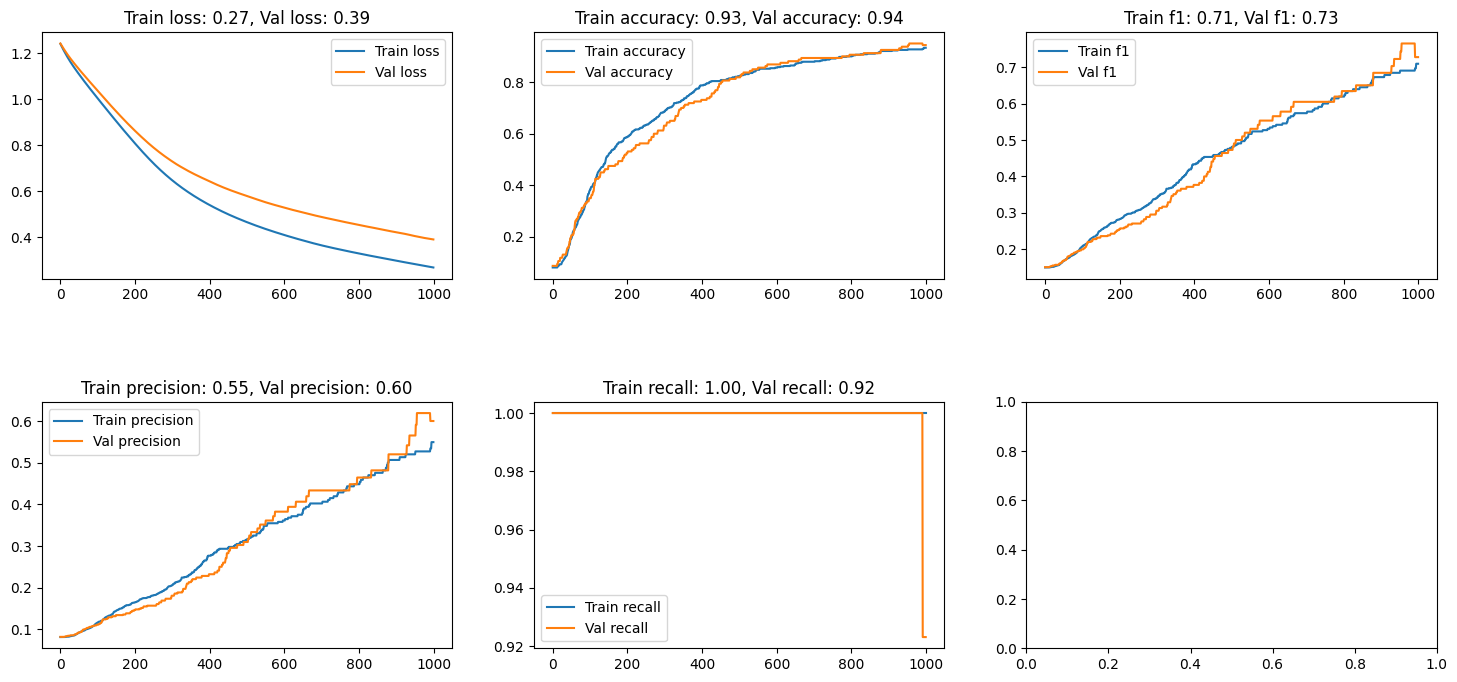

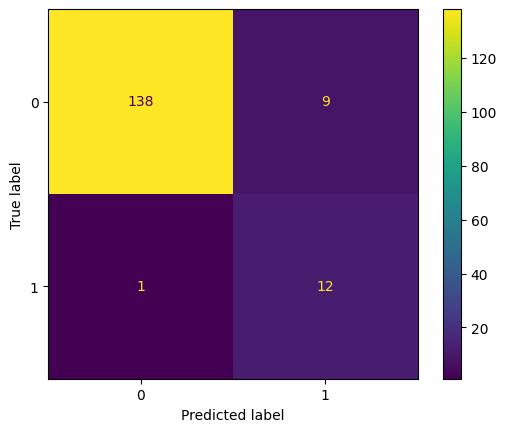

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97       147
         1.0       0.57      0.92      0.71        13

    accuracy                           0.94       160
   macro avg       0.78      0.93      0.84       160
weighted avg       0.96      0.94      0.94       160



In [152]:
metrics_handler = PokemonClassifierMetricsHandler(
    train_dataset_len=len(train_loader.dataset),
    val_dataset_len=len(validate_loader.dataset),
    device=device,
)
model = learn_model(
    train_loader=train_loader,
    val_loader=validate_loader,
    epochs=1000,
    n_layers=1,
    act_func=nn.ReLU(),
    metrics_handler=metrics_handler,
    device=device,
)
metrics_handler.plot()
logits = model(x_test_tensor.to(device))
clf_report(logits, y_test_tensor)

Цикл перебора моделей с разными параметрами и кросс валидацией (т. к данных мало хочется получить более менее объективную оценку)

In [153]:
class PokemonClassifierSimpleMetricsHandler(BatchMetricsHandlerProtocol):
    """Упрощенный обработчик для вычисления метрик классификатора покемонов."""

    def __init__(self, device: str):
        super().__init__()
        self.metrics = torchmetrics.MetricCollection(
            {"f1": BinaryF1Score(), "acc": BinaryAccuracy(), "precision": BinaryPrecision(), "recall": BinaryRecall()},
        ).to(device)

    def handle(self, logits: torch.Tensor, targets: torch.Tensor, loss: torch.Tensor, mode: EpochMode) -> None:
        """Собирает метрики только на инференсе."""
        proba_coef = 0.5
        preds = (torch.sigmoid(logits) > proba_coef).float()
        if mode is EpochMode.INFERENCE:
            self.metrics.update(preds, targets)

    def epoch_end(self, mode: EpochMode) -> None:
        """Ничего не делать в конце каждой эпохи."""
        return

    def end_learning(self) -> None:
        """Расчет метрик в конце обучения."""
        self.metrics.compute()

    def get_metrics_as_dict(self) -> dict[str, float]:
        """Получить метрики как словарь."""
        results = self.metrics.compute()
        return {k: v.item() for k, v in results.items()}

In [154]:
torch.manual_seed(42)

grid = {
    "epochs": [1000, 5000, 10000],
    "n_layers": [1, 2, 3, 4],
    "act_func": [nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU],
    "optim": [(torch.optim.Adam, None), (torch.optim.SGD, {"momentum": 0.9})],
}

keys = list(grid.keys())
combinations = list(itertools.product(*grid.values()))
comb_len = len(combinations)

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Объединение тренировочных и валидационных тензоров
x_total = torch.cat([x_train_tensor, x_validate_tensor], dim=0).to(device=device)
y_total = torch.cat([y_train_tensor, y_validate_tensor], dim=0).to(device=device)
full_dataset = TensorDataset(x_total, y_total)

for comb_num, combo in enumerate(combinations, start=1):
    tqdm.write(f"================Combination [{comb_num}/{comb_len}]================")

    params = dict(zip(keys, combo, strict=False))
    act_func_instance = params["act_func"]()

    # Метрики будут рассчитаны для всех фолдов и усреднены
    metrics_logger = PokemonClassifierSimpleMetricsHandler(device=device)

    for train_idx, val_idx in tqdm(kf.split(full_dataset), desc="Fold", total=5):
        # 3. Подмножества
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        # 4. DataLoader-ы
        subset_train_loader = DataLoader(train_subset, batch_size=1024, shuffle=True)
        subset_val_loader = DataLoader(val_subset, batch_size=1024)

        model = learn_model(
            train_loader=subset_train_loader,
            val_loader=subset_val_loader,
            epochs=params["epochs"],
            n_layers=params["n_layers"],
            act_func=act_func_instance,
            optim=params["optim"],
            metrics_handler=metrics_logger,
            device=device,
        )

    metrics_dict = metrics_logger.get_metrics_as_dict()
    for name, value in metrics_dict.items():
        tqdm.write(f"{name.capitalize():<10}: {value:.4f}")
    results.append(params | metrics_dict)


================Combination [1/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7290
F1        : 0.3689
Precision : 0.2275
Recall    : 0.9746
================Combination [2/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7057
F1        : 0.3542
Precision : 0.2155
Recall    : 0.9932
================Combination [3/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7414
F1        : 0.3859
Precision : 0.2391
Recall    : 1.0000
================Combination [4/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7371
F1        : 0.3820
Precision : 0.2361
Recall    : 1.0000
================Combination [5/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7275
F1        : 0.3736
Precision : 0.2297
Recall    : 1.0000
================Combination [6/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.6630
F1        : 0.3161
Precision : 0.1893
Recall    : 0.9585
================Combination [7/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7289
F1        : 0.3690
Precision : 0.2275
Recall    : 0.9757
================Combination [8/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7063
F1        : 0.3547
Precision : 0.2159
Recall    : 0.9935
================Combination [9/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.9169
F1        : 0.6324
Precision : 0.4936
Recall    : 0.8798
================Combination [10/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8881
F1        : 0.5373
Precision : 0.4046
Recall    : 0.7995
================Combination [11/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8797
F1        : 0.5617
Precision : 0.3989
Recall    : 0.9489
================Combination [12/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8287
F1        : 0.4707
Precision : 0.3143
Recall    : 0.9373
================Combination [13/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8394
F1        : 0.4721
Precision : 0.3221
Recall    : 0.8842
================Combination [14/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.4865
F1        : 0.1508
Precision : 0.0871
Recall    : 0.5612
================Combination [15/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.9179
F1        : 0.6340
Precision : 0.4971
Recall    : 0.8752
================Combination [16/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8874
F1        : 0.5376
Precision : 0.4033
Recall    : 0.8057
================Combination [17/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8202
F1        : 0.4538
Precision : 0.3013
Recall    : 0.9196
================Combination [18/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.5701
F1        : 0.2682
Precision : 0.1556
Recall    : 0.9694
================Combination [19/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8825
F1        : 0.5569
Precision : 0.4015
Recall    : 0.9086
================Combination [20/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7635
F1        : 0.4007
Precision : 0.2523
Recall    : 0.9733
================Combination [21/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7785
F1        : 0.4066
Precision : 0.2599
Recall    : 0.9342
================Combination [22/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.2210
F1        : 0.1295
Precision : 0.0712
Recall    : 0.7134
================Combination [23/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.8387
F1        : 0.4682
Precision : 0.3198
Recall    : 0.8740
================Combination [24/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.5739
F1        : 0.2708
Precision : 0.1573
Recall    : 0.9735
================Combination [25/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.9090
F1        : 0.5970
Precision : 0.4662
Recall    : 0.8297
================Combination [26/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.6269
F1        : 0.2252
Precision : 0.1354
Recall    : 0.6672
================Combination [27/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.9070
F1        : 0.5995
Precision : 0.4610
Recall    : 0.8572
================Combination [28/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7553
F1        : 0.3787
Precision : 0.2385
Recall    : 0.9178
================Combination [29/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.7974
F1        : 0.4199
Precision : 0.2736
Recall    : 0.9025
================Combination [30/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.3205
F1        : 0.1252
Precision : 0.0699
Recall    : 0.5982
================Combination [31/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.9055
F1        : 0.5888
Precision : 0.4554
Recall    : 0.8328
================Combination [32/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc       : 0.6314
F1        : 0.2288
Precision : 0.1378
Recall    : 0.6729
================Combination [33/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9029
F1        : 0.5945
Precision : 0.4500
Recall    : 0.8757
================Combination [34/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8749
F1        : 0.5583
Precision : 0.3914
Recall    : 0.9732
================Combination [35/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9027
F1        : 0.6059
Precision : 0.4516
Recall    : 0.9201
================Combination [36/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8817
F1        : 0.5782
Precision : 0.4070
Recall    : 0.9978
================Combination [37/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8920
F1        : 0.5915
Precision : 0.4270
Recall    : 0.9622
================Combination [38/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8355
F1        : 0.4948
Precision : 0.3297
Recall    : 0.9916
================Combination [39/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9029
F1        : 0.5943
Precision : 0.4498
Recall    : 0.8756
================Combination [40/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8746
F1        : 0.5579
Precision : 0.3910
Recall    : 0.9735
================Combination [41/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9443
F1        : 0.6987
Precision : 0.6229
Recall    : 0.7953
================Combination [42/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9299
F1        : 0.6762
Precision : 0.5413
Recall    : 0.9009
================Combination [43/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9304
F1        : 0.6443
Precision : 0.5507
Recall    : 0.7763
================Combination [44/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9127
F1        : 0.6346
Precision : 0.4808
Recall    : 0.9329
================Combination [45/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9260
F1        : 0.6585
Precision : 0.5269
Recall    : 0.8779
================Combination [46/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.7241
F1        : 0.3335
Precision : 0.2075
Recall    : 0.8499
================Combination [47/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9443
F1        : 0.6944
Precision : 0.6262
Recall    : 0.7792
================Combination [48/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9293
F1        : 0.6745
Precision : 0.5387
Recall    : 0.9020
================Combination [49/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9201
F1        : 0.6063
Precision : 0.5054
Recall    : 0.7577
================Combination [50/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8560
F1        : 0.5185
Precision : 0.3560
Recall    : 0.9544
================Combination [51/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9254
F1        : 0.6327
Precision : 0.5272
Recall    : 0.7911
================Combination [52/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9051
F1        : 0.6078
Precision : 0.4575
Recall    : 0.9051
================Combination [53/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9121
F1        : 0.6011
Precision : 0.4762
Recall    : 0.8148
================Combination [54/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.2308
F1        : 0.1283
Precision : 0.0706
Recall    : 0.6965
================Combination [55/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9238
F1        : 0.6233
Precision : 0.5206
Recall    : 0.7764
================Combination [56/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8568
F1        : 0.5207
Precision : 0.3576
Recall    : 0.9574
================Combination [57/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9407
F1        : 0.6856
Precision : 0.6019
Recall    : 0.7965
================Combination [58/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8649
F1        : 0.5092
Precision : 0.3612
Recall    : 0.8629
================Combination [59/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9319
F1        : 0.6383
Precision : 0.5613
Recall    : 0.7397
================Combination [60/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9029
F1        : 0.5967
Precision : 0.4504
Recall    : 0.8835
================Combination [61/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9173
F1        : 0.6179
Precision : 0.4945
Recall    : 0.8233
================Combination [62/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.2491
F1        : 0.1272
Precision : 0.0702
Recall    : 0.6735
================Combination [63/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.9413
F1        : 0.6718
Precision : 0.6154
Recall    : 0.7396
================Combination [64/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Acc       : 0.8655
F1        : 0.5106
Precision : 0.3624
Recall    : 0.8639
================Combination [65/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9268
F1        : 0.6430
Precision : 0.5325
Recall    : 0.8114
================Combination [66/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9086
F1        : 0.6293
Precision : 0.4694
Recall    : 0.9542
================Combination [67/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9170
F1        : 0.6082
Precision : 0.4934
Recall    : 0.7926
================Combination [68/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9089
F1        : 0.6337
Precision : 0.4706
Recall    : 0.9697
================Combination [69/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9213
F1        : 0.6480
Precision : 0.5091
Recall    : 0.8909
================Combination [70/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.8740
F1        : 0.5614
Precision : 0.3914
Recall    : 0.9927
================Combination [71/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9271
F1        : 0.6445
Precision : 0.5339
Recall    : 0.8128
================Combination [72/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9085
F1        : 0.6290
Precision : 0.4689
Recall    : 0.9550
================Combination [73/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9420
F1        : 0.6595
Precision : 0.6306
Recall    : 0.6911
================Combination [74/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9419
F1        : 0.7133
Precision : 0.5951
Recall    : 0.8902
================Combination [75/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9331
F1        : 0.6361
Precision : 0.5697
Recall    : 0.7200
================Combination [76/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9299
F1        : 0.6744
Precision : 0.5418
Recall    : 0.8930
================Combination [77/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9325
F1        : 0.6435
Precision : 0.5637
Recall    : 0.7497
================Combination [78/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.8173
F1        : 0.4514
Precision : 0.2986
Recall    : 0.9249
================Combination [79/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9432
F1        : 0.6618
Precision : 0.6407
Recall    : 0.6844
================Combination [80/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9415
F1        : 0.7123
Precision : 0.5930
Recall    : 0.8917
================Combination [81/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9310
F1        : 0.6251
Precision : 0.5597
Recall    : 0.7077
================Combination [82/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9029
F1        : 0.6018
Precision : 0.4513
Recall    : 0.9031
================Combination [83/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9288
F1        : 0.6392
Precision : 0.5432
Recall    : 0.7765
================Combination [84/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9285
F1        : 0.6649
Precision : 0.5370
Recall    : 0.8729
================Combination [85/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9264
F1        : 0.6282
Precision : 0.5327
Recall    : 0.7656
================Combination [86/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.3538
F1        : 0.1487
Precision : 0.0832
Recall    : 0.6944
================Combination [87/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9337
F1        : 0.6495
Precision : 0.5694
Recall    : 0.7559
================Combination [88/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9020
F1        : 0.5977
Precision : 0.4483
Recall    : 0.8963
================Combination [89/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9443
F1        : 0.6901
Precision : 0.6301
Recall    : 0.7627
================Combination [90/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9028
F1        : 0.5871
Precision : 0.4483
Recall    : 0.8505
================Combination [91/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9327
F1        : 0.6305
Precision : 0.5693
Recall    : 0.7064
================Combination [92/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9243
F1        : 0.6431
Precision : 0.5211
Recall    : 0.8399
================Combination [93/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9313
F1        : 0.6568
Precision : 0.5529
Recall    : 0.8088
================Combination [94/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.2402
F1        : 0.1274
Precision : 0.0703
Recall    : 0.6829
================Combination [95/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9449
F1        : 0.6692
Precision : 0.6530
Recall    : 0.6862
================Combination [96/96]================


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Acc       : 0.9022
F1        : 0.5838
Precision : 0.4461
Recall    : 0.8443


Преобразование списка собранных метрик и параметров в DataFrame

In [157]:
grid_metrics = pd.DataFrame(results)
grid_metrics.head()

,epochs,n_layers,act_func,optim,acc,f1,precision,recall
0,1000,1,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.729033,0.368869,0.227485,0.974577
1,1000,1,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.705705,0.354184,0.215519,0.993231
2,1000,1,<class 'torch.nn.modules.activation.Tanh'>,"(<class 'torch.optim.adam.Adam'>, None)",0.741442,0.385933,0.239106,1.000000
3,1000,1,<class 'torch.nn.modules.activation.Tanh'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.737059,0.381957,0.236061,1.000000
4,1000,1,<class 'torch.nn.modules.activation.Sigmoid'>,"(<class 'torch.optim.adam.Adam'>, None)",0.727538,0.373595,0.229706,1.000000


### Какая комбинация дает наилучшую точность на тестовой выборке?


Вывод топ 10 лучших параметров для модели по метрике f1

In [159]:
grid_metrics.sort_values(by="f1", ascending=False).head(10)

,epochs,n_layers,act_func,optim,acc,f1,precision,recall
73,10000,2,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.941870,0.713339,0.595120,0.890169
79,10000,2,<class 'torch.nn.modules.activation.LeakyReLU'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.941472,0.712293,0.592989,0.891692
40,5000,2,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.944256,0.698652,0.622939,0.795315
46,5000,2,<class 'torch.nn.modules.activation.LeakyReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.944265,0.694365,0.626180,0.779215
88,10000,4,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.944332,0.690052,0.630052,0.762683
56,5000,4,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.940653,0.685620,0.601852,0.796477
41,5000,2,<class 'torch.nn.modules.activation.ReLU'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.929908,0.676226,0.541252,0.900881
47,5000,2,<class 'torch.nn.modules.activation.LeakyReLU'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.929271,0.674520,0.538662,0.902023
75,10000,2,<class 'torch.nn.modules.activation.Tanh'>,"(<class 'torch.optim.sgd.SGD'>, {'momentum': 0...",0.929947,0.674432,0.541805,0.893035
62,5000,4,<class 'torch.nn.modules.activation.LeakyReLU'>,"(<class 'torch.optim.adam.Adam'>, None)",0.941295,0.671845,0.615444,0.739627


### Сделайте предсказания целевой переменной для тестовой выборки. Постройте матрицу ошибок и рассчитайте метрики качества. 

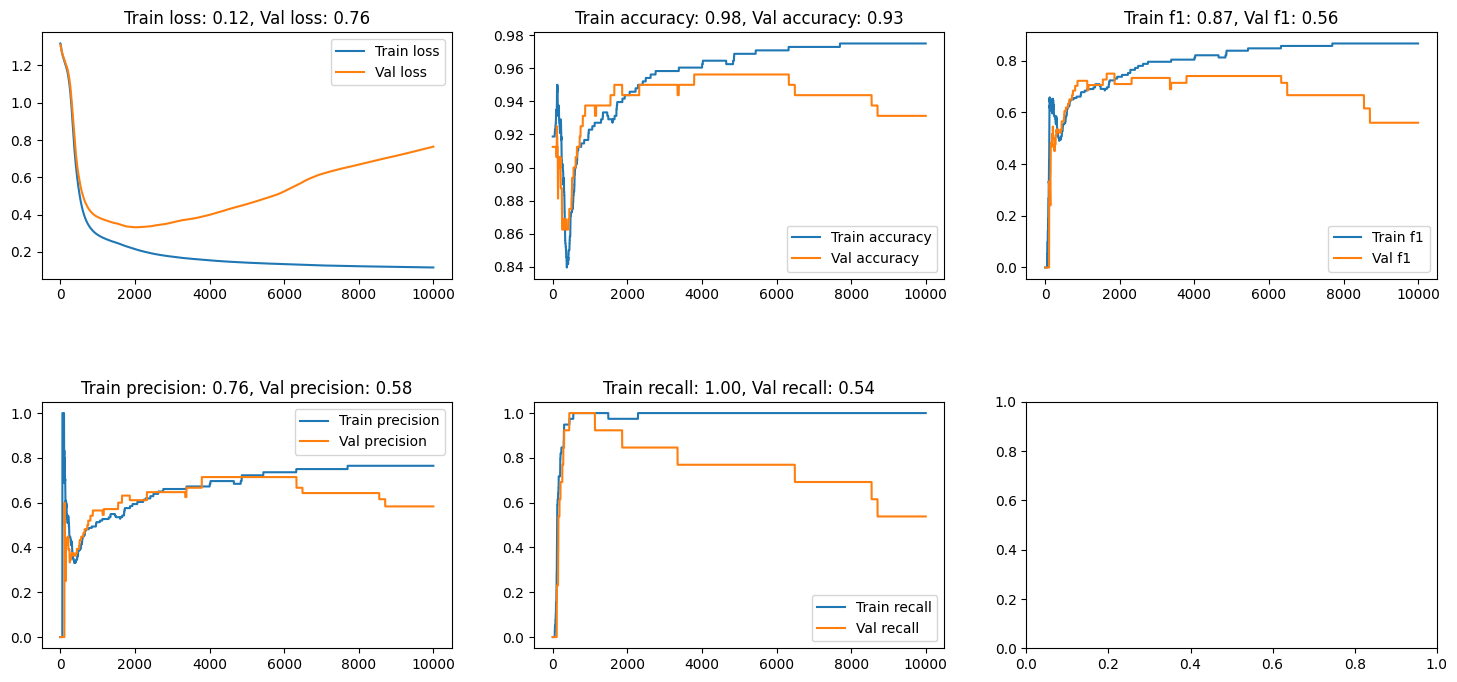

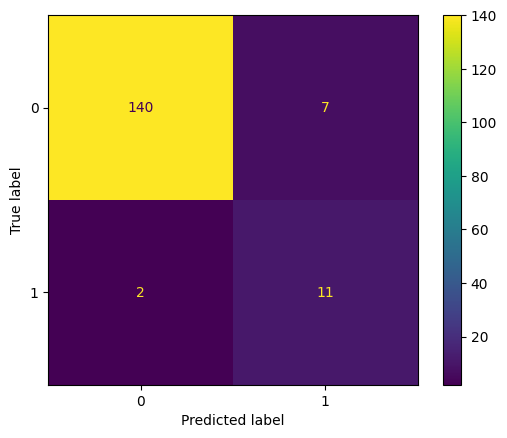

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       147
         1.0       0.61      0.85      0.71        13

    accuracy                           0.94       160
   macro avg       0.80      0.90      0.84       160
weighted avg       0.96      0.94      0.95       160



In [162]:
metrics_handler = PokemonClassifierMetricsHandler(
    train_dataset_len=len(train_loader.dataset),
    val_dataset_len=len(validate_loader.dataset),
    device=device,
)
model = learn_model(
    train_loader=train_loader,
    val_loader=validate_loader,
    epochs=10000,
    n_layers=2,
    act_func=nn.ReLU(),
    metrics_handler=metrics_handler,
    device=device,
    optim=(torch.optim.SGD, {"momentum": 0.9}),
)
metrics_handler.plot()
logits = model(x_test_tensor.to(device))
clf_report(logits, y_test_tensor)

По графикам видно тенденцию к переобучению и деградации модели после 6000 эпох. Можно попробовать ограничить количество эпох обучения и протестировать модель снова.

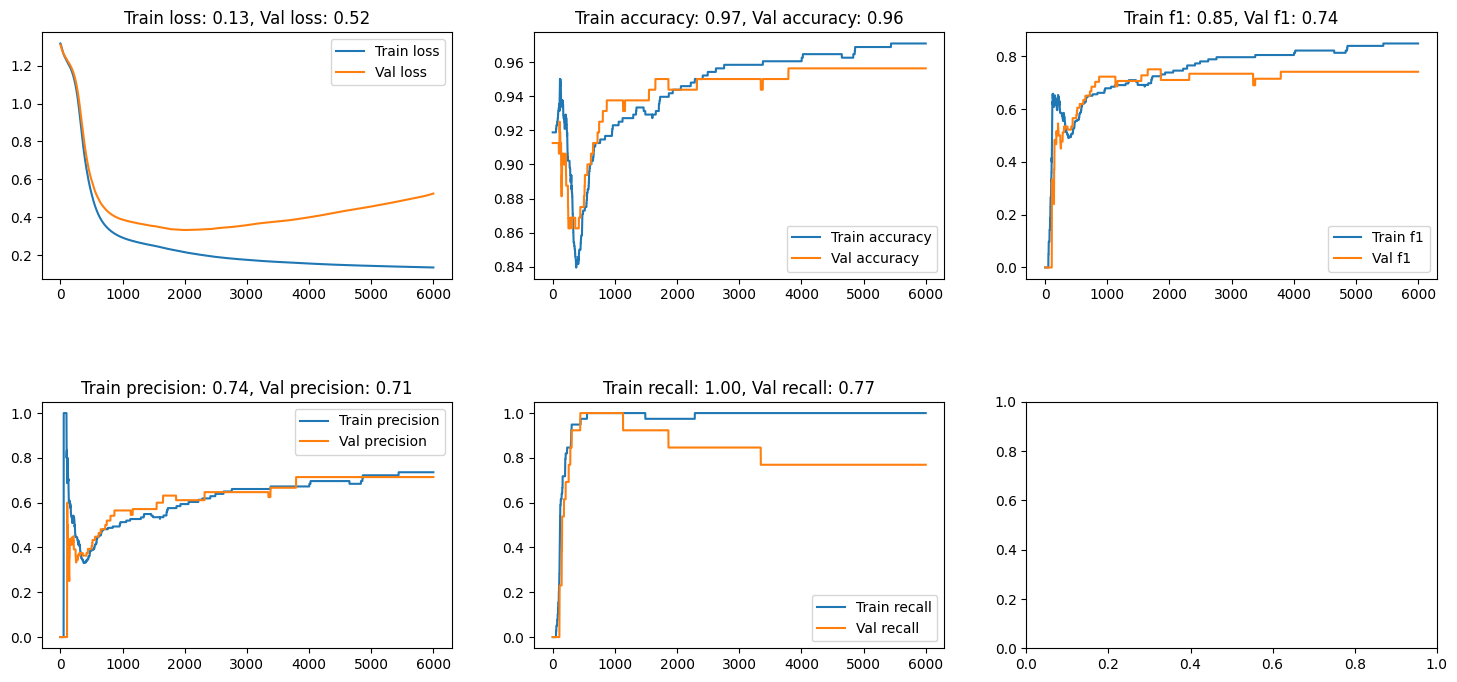

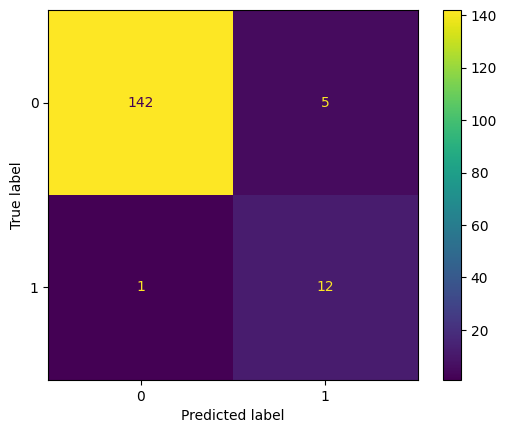

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       147
         1.0       0.71      0.92      0.80        13

    accuracy                           0.96       160
   macro avg       0.85      0.94      0.89       160
weighted avg       0.97      0.96      0.96       160



In [164]:
metrics_handler = PokemonClassifierMetricsHandler(
    train_dataset_len=len(train_loader.dataset),
    val_dataset_len=len(validate_loader.dataset),
    device=device,
)
model = learn_model(
    train_loader=train_loader,
    val_loader=validate_loader,
    epochs=6000,
    n_layers=2,
    act_func=nn.ReLU(),
    metrics_handler=metrics_handler,
    device=device,
    optim=(torch.optim.SGD, {"momentum": 0.9}),
)
metrics_handler.plot()
logits = model(x_test_tensor.to(device))
clf_report(logits, y_test_tensor)

После уменьшения количество эпох метрики на тестовых данных улучшились.

### Сделайте выводы относительно полученных моделей и их качества

Модель хорошо справляется с задачей классификации несмотря на сильный дисбаланс классов. На тестовой выборке удается найти 92% (recall - 0.92) легендарных покемонов. При этом довольно таки часто бывают ложные срабатывания - в 29% случаев (precision 0.71). Для решения задачи классификации покемонов - отличные результаты.

### Сравните качество нейросети с ансамблевыми моделями классификаторов

Если сравнивать полученную модель с бустингами - результаты нейросетей чуть лучше. Также необходимо отметить то, что интерпретация данных с нейросетями невозможна в отличии от алгоритмов бустинга, где можно посмотреть feature important.

Полученные метрики для нейросети:
|class number|precision  |  recall | f1-score  | support|
|------------|-----------|---------|-----------|--------|
|0           |0.99       | 0.97    | 0.98      | 147    |
|1           |0.71       |0.92     | 0.80      | 13     |

Полученные метрики для CatBoost:
|class number|precision  |  recall | f1-score  | support|
|------------|-----------|---------|-----------|--------|
|0           |0.99       | 0.96    | 0.97      | 147    |
|1           |0.65       |0.85     | 0.73      | 13     |